In [80]:
import torch
import torchvision

# we use torch.cuda.Event(enable_timing=True) to measure time
# from timeit import default_timer as timer
# import time

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import collections           # for ordered_dictionnary
import torch.nn.init as init # to initialize model

import copy                  # for copy.deepcopy( ... )

import matplotlib.pyplot as plt
import numpy as np

from __future__ import print_function, division
import os
from PIL import Image
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import collections
import torch.nn.init as init

# import dill
import pickle

In [82]:
random_seed= 2019
batch_size = 8
validation_split = .2
shuffle_dataset = True
num_workers = 0        # dataloader issues with numworkers > 0

def multby255 (pic) :
    return pic.mul(255)

# setting up data loader
root = './data_catdogs/trainset/'
                                           
data_transforms = {
    'augmented': transforms.Compose([
        transforms.RandomGrayscale(p=0.15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop(80, scale=(0.85, 1.0), ratio=(0.8, 1.2), interpolation=2),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Lambda(multby255)
    ]),
    'normal': transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(multby255)
    ])
}

# to be able to train and valide on both the original and the augmented dataset
train_dataset_augm = torchvision.datasets.ImageFolder(root=root,transform=data_transforms["augmented"])
train_dataset_norm = torchvision.datasets.ImageFolder(root=root,transform=data_transforms["normal"])

# Creating data indices for training and validation splits:
train_dataset_size = len(train_dataset_augm)
indices = list(range(train_dataset_size))
split = int(np.floor(validation_split * train_dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# 
batch_size = 32
train_norm_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
train_augm_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_norm_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
valid_augm_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

compute size

In [72]:
dummy_train_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=1, sampler=train_sampler, num_workers=0)
dummy_valid_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=1, sampler=valid_sampler, num_workers=0)
training_dataset_size  = dummy_train_loader.__len__()
testing_dataset_size = dummy_valid_loader.__len__()
del dummy_train_loader 
del dummy_valid_loader 

Setting the directory of the pictures

Display some samples

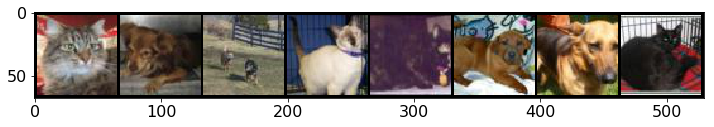

    0     1     1     0     0     1     1     0


In [83]:
batch_size = 8
# picture_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
pict_n_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
pict_a_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

# functions to show an image

def imshow(img):
    npimg = img.numpy() / 255
    # npimg = img.numpy() 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(pict_n_loader) :
    if i > 0 : break

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % labels[j].item() for j in range(min(batch_size,8))))

set the device

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## The model 
architecture taken from : https://github.com/MaximumEntropy/welcome_tutorials/tree/pytorch/pytorch

In [7]:
class MLP(nn.Module):
    def __init__(self, h1, h2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3*64*64, h1)
        self.fc2 = nn.Linear(h1 , h2)
        self.fc3 = nn.Linear(h2 , 1)

    def forward(self, x):
        x = x.view( -1, 3*64*64 )
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [8]:
class Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self, kernel_sz = 3 ):
        
        if kernel_sz % 2 == 0 :
            raise ValueError("kernel size must be odd")
        pad = kernel_sz // 2 
        
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=( kernel_sz , kernel_sz ), padding=pad ),
            # nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=( kernel_sz , kernel_sz), padding=pad),
            # nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=( kernel_sz , kernel_sz), padding=pad),
            # nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(kernel_sz , kernel_sz), padding=pad),
            # nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # 
        self.fct = nn.Linear(4*4*128, 1)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 4*4*128)
        x = torch.sigmoid(self.fct(x))
        # x = self.fct(x)
        # x = F.softmax(self.fct(x),dim=-1)
        return x

In [9]:
class Classifier2(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([11,9,9,7,3,3])
        pad = kernel_sz // 2 
        pad[4] = 0
        
        super(Classifier2, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[2],kernel_sz[2]) , padding=pad[2]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # 
        self.fct1 = nn.Linear(512, 512)
        self.fct2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze()
        x = F.relu(self.fct1(x))
        x = torch.sigmoid(self.fct2(x))
        return x

taken from :  
https://medium.com/@harsathAI/cats-and-dogs-classifier-convolutional-neural-network-with-python-and-tensorflow-9-steps-of-6259c92802f3

In [10]:
class Classifier3(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([5,5,5,5,3,3])
        # kernel_sz = np.array([3,3,3,3,3,3])
        pad = kernel_sz // 2 
        # pad[4] = 0
        
        super(Classifier3, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.ReLU(),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[2],kernel_sz[2]) , padding=pad[2]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # 
        self.fct = nn.Linear(8*8*256, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,8*8*256)
        x = F.relu(self.fct(x))
        # x = torch.sigmoid(x)
        x = F.softmax(x,dim=-1)
        return x

In [11]:
class Classifier4(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([5,5,5,5,3,3])
        pad = kernel_sz // 2 
        pad[5] = 0
        
        super(Classifier4, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # 
        self.fct1 = nn.Linear(1*1*512, 512)
        self.fct2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,1*1*512)
        x = F.relu(self.fct1(x))
        x = F.relu(self.fct2(x))
        x = F.softmax(x,dim=-1)
        return x

In [12]:
class Classifier5(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([5,5,3,3,3,3,3,3])
        pad = kernel_sz // 2 
        pad[7] = 0 
        
        super(Classifier5, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),

            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 7
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[6], kernel_sz[6]) , padding=pad[6]),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
            
        )
        # 
        self.fct1b = nn.Linear(1*1*512, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,1*1*512)
        x = F.relu(self.fct1b(x))
        x = F.softmax(x,dim=-1)
        return x

In [13]:
class Classifier6(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([11,9,7,3,3,3,3,3,2])
        pad = kernel_sz // 2 
        pad[8] = 0 
        
        super(Classifier6, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1, feature map size = 64^2
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, feature map size = 32^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, feature map size = 16^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=1, padding=1),

            # Layer 4, feature map size = 16^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=1, padding=1),

            # Layer 5, feature map size = 16^2
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=1, padding=1),
            
            # Layer 6, feature map size = 16^2
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 7, feature map size = 8^2
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size= (kernel_sz[6], kernel_sz[6]) , padding=pad[6]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 8, feature map size = 4^2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[7], kernel_sz[7]) , padding=pad[7]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 9, feature map size = 2^2
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[8], kernel_sz[8]) , padding=pad[8]),
            nn.Tanh(),      
        )
        # 
        self.fct1b = nn.Linear(1*1*512, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,1*1*512)
        x = F.softmax( self.fct1b(x) ,dim=-1)
        return x

Print the number of parameters in each models and display the computation 

In [42]:
import torchvision.models # for vgg16

def number_of_params( net , display_comp = False ) :
    nb_param  = 0
    depth     = 0 # count the number of different bias
    param_lst = " "
    for i, (key, value) in enumerate( net.state_dict().items() ) :
        if key.endswith("bias") :
            depth = depth + 1
            
        if i == 0 :
            param_lst = param_lst + "\n ({:<20}    ".format( key + ")" )
        else :
            param_lst = param_lst + "\n ({:<20}  + ".format( key + ")" )
            
            
        nb_param_tmp = 1
        
        for j , x in enumerate(value.size()) :
            if j == 0 :
                param_lst = param_lst + "{xx}".format( xx = x ) 
            else :
                param_lst = param_lst + "*{xx}".format( xx = x ) 
                               
            nb_param_tmp = nb_param_tmp * x
                   
        nb_param = nb_param + nb_param_tmp
        
    if display_comp: 
        print( "number of params = " , nb_param , " = ", param_lst  )
        
    return nb_param, depth
    
# mytestnet = Classifier( kernel_sz = 9  )
# number_of_params( mytestnet )
# del mytestnet
mytestnet = Classifier6( )
_ , _ = number_of_params( mytestnet, display_comp = True )
del mytestnet
# mytestnet = torchvision.models.vgg16( pretrained=False, num_classes=2, init_weights=True )
# number_of_params( mytestnet )
# del mytestnet
# mytestnet = MLP( h1 = 500, h2= 500)
# number_of_params( mytestnet )
# del mytestnet

number of params =  1550882  =   
 (conv.0.weight)          16*3*11*11
 (conv.0.bias)          + 16
 (conv.3.weight)        + 32*16*9*9
 (conv.3.bias)          + 32
 (conv.6.weight)        + 64*32*9*9
 (conv.6.bias)          + 64
 (conv.9.weight)        + 128*64*3*3
 (conv.9.bias)          + 128
 (conv.12.weight)       + 128*128*3*3
 (conv.12.bias)         + 128
 (conv.15.weight)       + 128*128*3*3
 (conv.15.bias)         + 128
 (conv.18.weight)       + 128*128*3*3
 (conv.18.bias)         + 128
 (conv.21.weight)       + 256*128*3*3
 (conv.21.bias)         + 256
 (conv.24.weight)       + 512*256*2*2
 (conv.24.bias)         + 512
 (fct1b.weight)         + 2*512
 (fct1b.bias)           + 2


init method

In [15]:
def glorot_init ( layer ) :
    """
    Weiths are generated from U[-d,d] where d = sqrt(6/(fan_in + fan_out)), biases are set to zero
    """
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d :
        init.xavier_uniform_( layer.weight , gain=1 )
        layer.bias.data.fill_(0.0)

In [19]:
if True :
    del cudanet

In [93]:
save_state_dict_list = False
# save_state_dict_list = True
if save_state_dict_list :
    state_dict_list2 = copy.deepcopy(state_dict_list) 

In [94]:
set_starting_point = False 
# set_starting_point = True 
if set_starting_point :
    # cudanet.load_state_dict(state_dict_list[27])
    starting_net = copy.deepcopy(cudanet).cpu()

In [18]:
get_starting_point = False 
# get_starting_point = True 
if get_starting_point :
    cudanet = copy.deepcopy(starting_net)
else :
    cudanet = Classifier6()
    # doesnt seem to help much :
    cudanet.apply( glorot_init )
    
_ = cudanet.to(device)

In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
want_to_test = False
want_to_test = True
if want_to_test:
    with torch.no_grad() :
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            # if using BCE
            # labels = labels.float()
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cudanet(inputs).squeeze()
            loss = criterion(outputs, labels)
            
            print( outputs.size() , labels.size() )
            print( loss )

            break

torch.Size([8, 2]) torch.Size([8])
tensor(1.0402, device='cuda:0')


### Find a good initialization  
Try different random init, train them for 3 epoch, repeat until you find one than has learnt something

In [23]:
# del cudanet 
nb_epoch  = 3
nb_try    = 10
batch_size = 1*32
train_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)

state_dict_list = list()

torch.cuda.synchronize()

start = torch.cuda.Event(enable_timing=True)
end   = torch.cuda.Event(enable_timing=True)
start.record()

for trial in range(nb_try) :
    cudanet = Classifier6()
    cudanet.apply( glorot_init )
    _ = cudanet.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(cudanet.parameters(), lr=0.0005, momentum=0, weight_decay=0)
    correct = torch.tensor([0])
    total = torch.tensor([0])
    for epoch in range( nb_epoch ):  # loop over the dataset multiple times 

        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            # if using BCE :
            # labels = labels.float() 
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = cudanet(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            with torch.no_grad() :
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum()
        else : # print every epoch
            print('trial %d , epoch = %d, loss = %.8f' % (trial + 1, epoch + 1, running_loss / training_dataset_size)) # nb of sample per mini-batch
            running_loss = 0.0
            torch.cuda.synchronize()
            tmp_state_dict = {}
            for k, v in cudanet.state_dict().items():
                tmp_state_dict[k] = v.cpu()
            state_dict_list.append( tmp_state_dict )
            torch.cuda.synchronize()
    accuracy = 100*correct.double()/total.double()
    print("Accuracy for trial %d : %.4f %%" % (trial+1 , accuracy) )
    if accuracy > 53 :
        print('Successful search')
        break
    del cudanet
else : 
    print('Unsuccessful search')
    
end.record()
torch.cuda.synchronize()
print( "time required = " , start.elapsed_time(end)*0.001 , " s ")

trial 1 , epoch = 1, loss = 0.02092315
trial 1 , epoch = 2, loss = 0.02020542
trial 1 , epoch = 3, loss = 0.01972550
Accuracy for trial 1 : 62.1622 %
Successful search
time required =  104.59832812500001  s 


## Training the model  

Note : what seems to work best   
start with a good initialization (find one, save it, and load it instead of random init each time)  
(or 0.00075)  
begin with  : lr=0.0005   , batch_sz between 16 and 32  
change   to : lr=0.00005  , batch_sz between 32 and 4*32  

batch_sz >~ 2 * 64 , absolutely no learning

In [95]:
use_BCE = False
if use_BCE :
    criterion = nn.BCELoss() # Binary Cross Entropy 
else :
    criterion = nn.CrossEntropyLoss() # Cross Entropy 
    
optimizer = optim.SGD(cudanet.parameters(), lr=0.0005, momentum=0, weight_decay=0)
nb_epoch  = 20

In [96]:
batch_size = 1*32

# train_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
train_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)

state_dict_list = list()

torch.cuda.synchronize()

start = torch.cuda.Event(enable_timing=True)
end   = torch.cuda.Event(enable_timing=True)
start.record()

for epoch in range( nb_epoch ):  # loop over the dataset multiple times 
    
    # if epoch == 5 :
    #     optim.SGD(cudanet.parameters(), lr=0.00001, momentum=0.0, weight_decay=0)
        
    # if epoch == 10 :
    #     optim.SGD(cudanet.parameters(), lr=0.000001, momentum=0.0, weight_decay=0)
        
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        # if using BCE :
        # labels = labels.float() 
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        
        # is using CE, squeeze does nothing :
        outputs = cudanet(inputs).squeeze()
        
        # if i == 0 : print( outputs )
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    else : # print every epoch
        print('epoch = %d, loss = %.8f' % (epoch + 1, running_loss / training_dataset_size)) # nb of sample per mini-batch
        running_loss = 0.0
        torch.cuda.synchronize()
        tmp_state_dict = {}
        for k, v in cudanet.state_dict().items():
            tmp_state_dict[k] = v.cpu()
        state_dict_list.append( tmp_state_dict )
        torch.cuda.synchronize()
        
else : 
    print('Finished Training')
    
end.record()
torch.cuda.synchronize()
print( "time required = " , start.elapsed_time(end)*0.001 , " s ")

epoch = 1, loss = 0.01758661
epoch = 2, loss = 0.01736953
epoch = 3, loss = 0.01716705
epoch = 4, loss = 0.01704344
epoch = 5, loss = 0.01696056
epoch = 6, loss = 0.01690561
epoch = 7, loss = 0.01687439
epoch = 8, loss = 0.01676441
epoch = 9, loss = 0.01672076
epoch = 10, loss = 0.01673638
epoch = 11, loss = 0.01658519
epoch = 12, loss = 0.01655587
epoch = 13, loss = 0.01650902
epoch = 14, loss = 0.01643875
epoch = 15, loss = 0.01643020
epoch = 16, loss = 0.01624011
epoch = 17, loss = 0.01629318
epoch = 18, loss = 0.01631122
epoch = 19, loss = 0.01610884
epoch = 20, loss = 0.01618598
Finished Training
time required =  753.5205  s 


#### test accuracy of the current state on validation dataset

In [103]:
batch_size = 4*64
# validation_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)

correct = torch.tensor([0])
total = torch.tensor([0])

want_to_use_current_state = True

if not want_to_use_current_state :
    epoch = 28
    tmp_state_dict = state_dict_list[epoch]
    cuda_test_net = copy.deepcopy( cudanet )
    cuda_test_net.load_state_dict( tmp_state_dict )
    cuda_test_net.to(device)
else :
    cuda_test_net = cudanet
    
correct, total = correct.to(device) , total.to(device) 
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        # if using BCE
        # labels = labels.float()
        images, labels = images.to(device), labels.to(device)
        outputs = cuda_test_net(images).squeeze()
        # if using BCE
        # predicted = torch.where(outputs > 0.5, torch.ones_like(labels, device=device) , torch.zeros_like(labels, device=device) )
        # if using multi class cross entropy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('Accuracy of the network on the' , total.item() , 'test images: %.2f %%' 
          % ( (100 * correct.double()) / total.double()  )
     ) 

Accuracy of the network on the 3999 test images: 77.14 %


#### accuracy across epoch

In [98]:
train_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)

accuracy = torch.ones(nb_epoch,2, dtype=torch.float) * 100
for epoch , tmp_state_dict in enumerate(state_dict_list,0) :
    if epoch % 1 != 0 :
        continue
        
    cudaTOCPUnet = copy.deepcopy( cudanet )
    cudaTOCPUnet.load_state_dict( tmp_state_dict )
    cuda_test_net = copy.deepcopy(cudaTOCPUnet).to(device)
    
    correct = torch.tensor([0,0])
    total   = torch.tensor([0,0])
    
    correct, total = correct.to(device) , total.to(device) 
        
    loader_list = [ valid_loader , train_loader ]
    with torch.no_grad():
        for i, loader in enumerate(loader_list,0) :
            for data in loader:
                images, labels = data
                # if using BCE
                # labels = labels.float()
                images, labels = images.to(device), labels.to(device)
                outputs = cuda_test_net(images).squeeze()
                # if using BCE
                # predicted = torch.where(outputs > 0.5, torch.ones_like(labels, device=device) , torch.zeros_like(labels, device=device) )
                # if using multi class cross entropy
                _, predicted = torch.max(outputs.data, 1)
                total[i] += labels.size(0)
                correct[i] += (predicted == labels).sum()
    
    accuracy[epoch,:] = accuracy[epoch,:] * correct.type(torch.FloatTensor) / total.type(torch.FloatTensor)
    
    print('epoch %3d : Accuracy of the network on the test images: %.2f %% , training images %.2f %% ' 
              % ( epoch+1, accuracy[epoch,0] , accuracy[epoch,1] )
         )

epoch   1 : Accuracy of the network on the test images: 75.84 % , training images 75.35 % 
epoch   2 : Accuracy of the network on the test images: 75.77 % , training images 76.60 % 
epoch   3 : Accuracy of the network on the test images: 75.54 % , training images 76.89 % 
epoch   4 : Accuracy of the network on the test images: 74.49 % , training images 75.10 % 
epoch   5 : Accuracy of the network on the test images: 73.79 % , training images 74.12 % 
epoch   6 : Accuracy of the network on the test images: 74.44 % , training images 74.87 % 
epoch   7 : Accuracy of the network on the test images: 76.04 % , training images 77.20 % 
epoch   8 : Accuracy of the network on the test images: 75.84 % , training images 76.82 % 
epoch   9 : Accuracy of the network on the test images: 76.34 % , training images 77.50 % 
epoch  10 : Accuracy of the network on the test images: 76.44 % , training images 77.37 % 
epoch  11 : Accuracy of the network on the test images: 76.49 % , training images 77.94 % 

### Plot accuracy  
and save it 

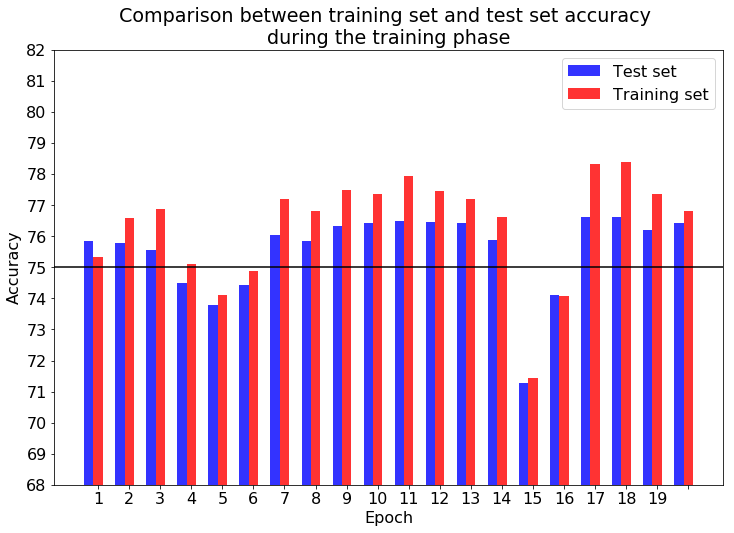

In [99]:
from matplotlib.pyplot import figure # to plot
import datetime                      # to include date in log file name
# import warnings
# warnings.filterwarnings('ignore')
#save it
want_log = True
path_to_save = "./log/" + datetime.datetime.now().strftime("%Y%B%d_%p%IH%MM")

# data to plot
n_groups = nb_epoch 
accuracy_toplot = accuracy.numpy()

tests_accuracy = accuracy_toplot[:,0]
train_accuracy = accuracy_toplot[:,1]

#
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (12 ,8)
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8
 
rects1 = plt.bar(index, tests_accuracy, bar_width,
                 alpha=opacity,
                 color='blue',
                 label='Test set')
 
rects2 = plt.bar(index + bar_width, train_accuracy, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Training set')

eps = 3 
top = min(int( np.ceil(accuracy_toplot.max() + eps)) , 100)
bot = max(int(np.floor(accuracy_toplot.min() - eps)) , 0  )


plt.ylim(bot, top)     # set the ylim to bottom, top
plt.axhline(y=75,color="black")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Comparison between training set and test set accuracy \nduring the training phase')
plt.xticks(index + bar_width, range(1,n_groups,1) )
plt.yticks( range(bot,top+1,1) )
plt.legend()

# plt.tight_layout()
if want_log :
    plt.savefig(path_to_save + ".png")
    with open(path_to_save + ".txt",'w+') as f:
        nb_params, depth = number_of_params(cudanet)
        line = "{name} : number of parameters = {n}, deptp = {d}.".format(name = cudanet.__doc__, n = nb_params, d=depth)
        f.write(line)
plt.show()

# Misc

#### print some test sample that the net misclassifies

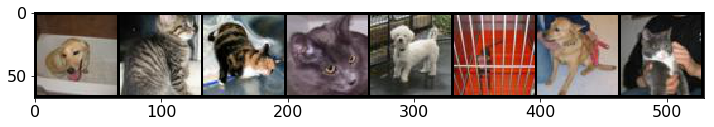

Probabilities goes from : 1 -> this is a dog for sure , to 0 -> cat for sure
this should be          :   1   , 0   , 0   , 0   , 1   , 1   , 1   , 0   
net associated prob     :   0.25, 0.82, 1.00, 0.79, 0.30, 0.13, 0.48, 0.97


In [92]:
batch_size = 8
valid_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)

nb_of_error = torch.tensor([8])
j = torch.tensor([0])
errorimages  = torch.empty(8,3,64,64)
errorlabels  = torch.empty(8)
erroroutputs = torch.empty(8)
for images, labels in valid_loader :
    images, labels = images.to(device), labels.to(device)
    outputs = cuda_test_net(images).squeeze()
    # if using BCE
    # predicted = torch.where(outputs > 0.5, torch.ones_like(labels, device=device) , torch.zeros_like(labels, device=device) )
    # if using multi class cross entropy
    _, predicted = torch.max(outputs.data, 1)
    if not (predicted == labels).sum() == labels.size()[0] :
        comparison = (predicted == labels)
        for i,b in enumerate( comparison ) :
            if b == 0 :
                errorimages[j,:,:,:] = copy.deepcopy(images[i,:,:,:]).cpu()
                errorlabels[j] = labels[i].clone().detach().requires_grad_(False).cpu()
                erroroutputs[j] = outputs[i,1].clone().detach().requires_grad_(False).cpu()
                j = j + 1
                if j.item() >= nb_of_error.item() :
                    break
        else :
            continue
        break
        
if j.item() == 0 :
    print( "no error found")
else :
    imshow( torchvision.utils.make_grid(errorimages) )
    
    print( "Probabilities goes from : 1 -> this is a dog for sure , to 0 -> cat for sure")
    print( "this should be          : " , ",".join( " %-4d" % nb.item() for nb in errorlabels ) ) 
    print( "net associated prob     : " , ",".join( "%5.2f" % nb.item() for nb in erroroutputs ) ) 

Does stuff

In [310]:
for i,(name,layer) in enumerate(cudanet.named_parameters(),1) :
    print(i , "name : " , name , " : \n" , layer.size() )

1 name :  conv.0.weight  : 
 torch.Size([16, 3, 5, 5])
2 name :  conv.0.bias  : 
 torch.Size([16])
3 name :  conv.3.weight  : 
 torch.Size([32, 16, 5, 5])
4 name :  conv.3.bias  : 
 torch.Size([32])
5 name :  conv.6.weight  : 
 torch.Size([64, 32, 5, 5])
6 name :  conv.6.bias  : 
 torch.Size([64])
7 name :  conv.9.weight  : 
 torch.Size([128, 64, 5, 5])
8 name :  conv.9.bias  : 
 torch.Size([128])
9 name :  conv.11.weight  : 
 torch.Size([128, 128, 5, 5])
10 name :  conv.11.bias  : 
 torch.Size([128])
11 name :  conv.13.weight  : 
 torch.Size([256, 128, 3, 3])
12 name :  conv.13.bias  : 
 torch.Size([256])
13 name :  fct.weight  : 
 torch.Size([2, 16384])
14 name :  fct.bias  : 
 torch.Size([2])


#### Vizualize conv weigths

conv.0.weight  =  [[ -1 -14   6   2   9   8 -12]
 [ 13   4   4  -5 -13  -1   3]
 [-12 -11 -13  10   3   7   1]
 [  3  -8  -6 -11 -13   1  -4]
 [  5   1  14   0   5 -10   0]
 [ -8  11  14  14  -5  -4 -11]
 [  8   0 -11   7 -10  -2 -14]]


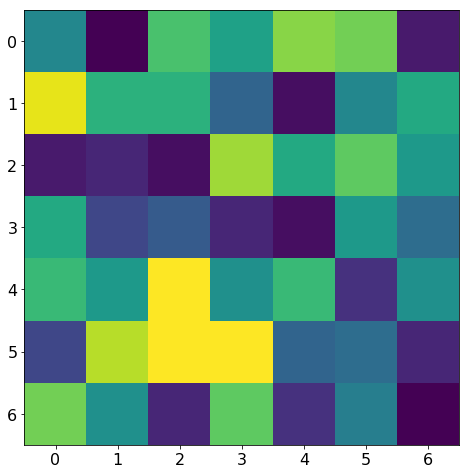

In [200]:
for layer, weight in cudanet.state_dict().items() :
    if layer.startswith("conv") and layer.endswith("weight") :
        tmp_weight = copy.deepcopy(weight.data).cpu().numpy() * 255
        tmp_weight = tmp_weight.astype(int)
        print(layer , " = " , tmp_weight[0,0,...])
        plt.imshow(tmp_weight[0,0,...])
        break
        

### Save and load models

In [104]:
# save current state only
saving_path = "./save/dev1num3model.pth"
cudanet_tocpu = cudanet.cpu()
tmp_state_dict = cudanet_tocpu.state_dict()
torch.save( tmp_state_dict , saving_path )

In [24]:
# load one state
loading_path = "./save/dev1num3model.pth"
cudanet_tocpu = Classifier6()
cudanet_tocpu.load_state_dict(torch.load(loading_path))
cudanet = copy.deepcopy( cudanet_tocpu ).to(device)

#### Save the state_dict of the model for each epoch on a local directory

In [105]:
local_path = "./save"
for epoch , tmp_state_dict in enumerate(state_dict_list,1) :
    saving_path = local_path + "/dev1num3model_for_epoch{Epoch}.pth".format( Epoch = epoch )
    torch.save( tmp_state_dict , saving_path)
    # print( saving_path )

#### load from file and set the load the state_dict of the last epoch on a object
the files have to be located in "./save" and named "dev1num3model_for_epoch{j}.pth" for j from ... to ...

In [107]:
local_path = "./save"
state_dict_list = list()

from_idx = 1
to_idx   = nb_epoch

for epoch in range( from_idx  , to_idx + 1 , 1 ):
    path = local_path + "/dev1num3model_for_epoch{Epoch}.pth".format( Epoch = epoch )
    tmp_dict = torch.load(path)
    state_dict_list.append(tmp_dict)
    # print( path )
else : 
    cudanet = Classifier6( )
    cudanet.load_state_dict(tmp_dict)
    cudanet.to(device)
    cudanet.eval()                     

### Other stuff  
see some models :  
https://pytorch.org/docs/stable/torchvision/models.html

dense net as in :  
https://pytorch.org/docs/stable/_modules/torchvision/models/densenet.html#densenet121

In [ ]:
# test to import greyscale with transforms.ToTensor()


In [ ]:
# check if there is an image of size 80
pict_a_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=1, sampler=valid_sampler, num_workers=num_workers)
for i, (images, labels) in enumerate(pict_a_loader) :
    if images.size()[3] == 80 :
        imshow(torchvision.utils.make_grid(images))
        break

In [28]:
with torch.no_grad() :
    A = torch.ones(5,5) + torch.transpose(torch.tensor([[1,2,3,4,5]],dtype=torch.float),1,0)
    xx = torch.ones(3,5,5)
    print(A)
    xx = torch.matmul(A, xx) 
    print( xx )
    xx = xx.view(-1,5*5)
    print(xx)
    

tensor([[2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4.],
        [5., 5., 5., 5., 5.],
        [6., 6., 6., 6., 6.]])
tensor([[[10., 10., 10., 10., 10.],
         [15., 15., 15., 15., 15.],
         [20., 20., 20., 20., 20.],
         [25., 25., 25., 25., 25.],
         [30., 30., 30., 30., 30.]],

        [[10., 10., 10., 10., 10.],
         [15., 15., 15., 15., 15.],
         [20., 20., 20., 20., 20.],
         [25., 25., 25., 25., 25.],
         [30., 30., 30., 30., 30.]],

        [[10., 10., 10., 10., 10.],
         [15., 15., 15., 15., 15.],
         [20., 20., 20., 20., 20.],
         [25., 25., 25., 25., 25.],
         [30., 30., 30., 30., 30.]]])
tensor([[10., 10., 10., 10., 10., 15., 15., 15., 15., 15., 20., 20., 20., 20.,
         20., 25., 25., 25., 25., 25., 30., 30., 30., 30., 30.],
        [10., 10., 10., 10., 10., 15., 15., 15., 15., 15., 20., 20., 20., 20.,
         20., 25., 25., 25., 25., 25., 30., 30., 30., 30., 30.],
        [10., 1

#### Deprecated

In [3]:
total_nb_of_sample = 9999 # total number of sample per class, this shouldn't be hardcoded
class labeledDataSet(torch.utils.data.Dataset):

    def __init__(self, label, idx_min , idx_max , root_dir ):
        """
        Args:
            label is either "Cat" or "Dog"
            load in the dataset picture no. idx_min to idx_max included
            root_dir(string): directory with all images with the same label
        """
        # super(labeledDataSet, self).__init__()
        dic = {"Cat" : int(1) , "Dog" : int(0)}
        
        if dic.get(label , "not found" ) == "not found" :
            raise ValueError("label must either be Cat or Dog")
            
        if idx_max > total_nb_of_sample or idx_min < 0 :
            raise ValueError("min, max index error")
            
        self.label_name = label
        self.idx_min = idx_min
        self.idx_max = idx_max
        self.label = dic[label]
        self.root_dir = root_dir
        self.load_data()
    
    def load_data(self) :
        size = self.__len__()
        
        self.data_tensor = torch.empty(size,3,64,64,dtype=torch.float)
        self.target_tensor = torch.ones(size,dtype=torch.long) * self.label
        
        for i,j in enumerate(range( self.idx_min , self.idx_max , 1 ),0) :
            img_path = self.root_dir +  "/{index}.{Label}.jpg".format(index=(j),Label=self.label_name)
            # image = io.imread(img_name)
            # print( i , " : " , io.imread(img_name).shape )
            # img = io.imread(img_name)
            # print( img_path )
            img = Image.open( img_path ).convert('RGB')
            """
            NOTE : There is at least one grey-scale picture of Einstein, manually remove it ?
            the greyscale (1 channel) images have to be converted to 3 channels tensors
            """   
            image = torch.from_numpy( np.transpose( img , (-1,-3,-2) ) )
            self.data_tensor[i,:,:,:] = image
        
    def __len__(self):
        # return len(self.name_frame)
        return (self.idx_max - self.idx_min + 1)

    def __getitem__(self, idx):
        return self.data_tensor[idx], self.target_tensor[idx]


In [ ]:

ture no 1             to (idx_sep)            belong to the training dataset
# picture no (idx_sep + 1) to (total_nb_of_sample) belong to the validation dataset
idx_sep = 8000

trainDogSet = labeledDataSet( "Dog", 1 , idx_sep , root_dir = dog_dir )
trainCatSet = labeledDataSet( "Cat", 1 , idx_sep , root_dir = cat_dir )

testsDogSet = labeledDataSet( "Dog", idx_sep + 1 , total_nb_of_sample , root_dir = dog_dir )
testsCatSet = labeledDataSet( "Cat", idx_sep + 1 , total_nb_of_sample , root_dir = cat_dir )
dog_dir = "./data_catdogs/trainset/Dog"
cat_dir = "./data_catdogs/trainset/Cat"

# picture no 1             to (idx_sep)            belong to the training dataset
# picture no (idx_sep + 1) to (total_nb_of_sample) belong to the validation dataset
idx_sep = 8000

trainDogSet = labeledDataSet( "Dog", 1 , idx_sep , root_dir = dog_dir )
trainCatSet = labeledDataSet( "Cat", 1 , idx_sep , root_dir = cat_dir )

testsDogSet = labeledDataSet( "Dog", idx_sep + 1 , total_nb_of_sample , root_dir = dog_dir )
testsCatSet = labeledDataSet( "Cat", idx_sep + 1 , total_nb_of_sample , root_dir = cat_dir )

trainset = torch.utils.data.ConcatDataset( [ trainDogSet , trainCatSet ] )
testsset = torch.utils.data.ConcatDataset( [ testsDogSet , testsCatSet ] )

( "img size = " , img.size() , "label size = " , label.size() )
testing_dataset_size  = testsCatSet.__len__() + testsDogSet.__len__()
training_dataset_size = trainCatSet.__len__() + trainDogSet.__len__()

print( "training dataset size = " , training_dataset_size ) 
print( "testing  dataset size = " , testing_dataset_size ) 
print( trainDogSet.__doc__ ) 
img, label =  trainDogSet.__getitem__(1)
print( "img size = " , img.size() , "label size = " , label.size() )